# **Hybrid 3D-CNN + LSTM Autoencoder-Based Video Quality Assessment and Selection**


The Hybrid 3D-CNN + LSTM Autoencoder-Based Video Quality Assessment and Selection method leverages both spatial and temporal features to evaluate and rank videos. The 3D-CNN encoder extracts spatial features across individual frames, while the LSTM layer captures temporal dependencies across sequences of frames, ensuring the model understands both visual content and motion patterns. The decoder reconstructs the frames from the learned latent space, enabling the calculation of key metrics such as reconstruction error (to measure how well the video is reproduced), SSIM (to assess structural similarity), and clustering inertia (to quantify the compactness and consistency of latent representations). These metrics are combined into a composite score, ranking videos based on their alignment with the model's learned patterns, smoothness of motion, and content quality, ensuring the selection of the most relevant and high-quality video among multiple candidates.

## Requirements

In order to train the models, the following Python and TensorFlow versions are required:  

Python: 3.10 or 3.11
TensorFlow: 2.17.0

In [ ]:
#Checking python and Tesnsorflow version
print ('Current Python version :')
!python --version

import sys
print(sys.executable)

import tensorflow as tf
print('Current Tesorflow version :'+ tf.__version__)

Current Python version :
Python 3.10.12
/usr/bin/python3
Current Tesorflow version :2.17.0


# Connect to google Drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder
# os.chdir('/content/gdrive/My Drive/Your Folder Name/Your sub Folder Name')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Best-Video-Selection')

Mounted at /content/gdrive


# 1. Importing the necessary libraries

Importing the required libraries for video processing.


In [ ]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, LSTM, Dense, Reshape
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Reshape
from tensorflow.keras.layers import LSTM, Dense
from sklearn.cluster import KMeans
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# 2. Autoencoder Model Definition

### Input Layer:   
Takes a sequence of video frames as input.  
Example shape: (10, 128, 128, 3) (10 frames, each 128x128 pixels with 3 color channels).  
3D-CNN Encoder (Spatial Feature Extraction)  

### Convolution Layers:  
Extract spatial features within each frame and minor temporal context between adjacent frames.  

### MaxPooling Layers:
Reduce the spatial dimensions, capturing only essential spatial patterns and reducing computation.  
Output at this stage: Compressed spatial representation for each frame.  

### Reshape Layer (Prepare Data for LSTM)  
Flattens the spatial dimensions of the encoded frames, converting them into a sequence format suitable for LSTM.  
Example transformation: (10, 32, 32, 64) becomes (10, 65536).  

### LSTM Layers (Temporal Feature Extraction)  

#### 1. First LSTM Layer:
Learns temporal dependencies across frames in the sequence.  
Example output: (10, 512) (10 frames, 512 hidden units per frame).  
#### 2. Dense Layer:
Transforms the LSTM output to match the input size required by the CNN decoder.  
#### 3. Reshape Layer (Prepare Data for 3D-CNN Decoder)  
Reshapes the LSTM output back to a 3D-CNN compatible format.  
Example transformation: (10, 512) becomes (10, 32, 32, 64).  
3D-CNN Decoder (Reconstruction)  

### UpSampling Layers:  
Restore the spatial dimensions to their original size.  

### Convolution Layers:
Reconstruct the original frames from the encoded representations.  

### Final Output:
Reconstructed video frames with the same dimensions as the input.  

### Loss Function (Mean Squared Error)  

The model is trained to minimize the difference between the original and reconstructed frames using MSE as the loss function.  

### Evaluation Metrics  
Reconstruction Error (Mean Squared Error)  

Measures how closely the reconstructed frames match the original ones.  
SSIM Score (Structural Similarity Index)  

Evaluates the perceptual similarity between the original and reconstructed frames, focusing on structural patterns.  
Latent Space Clustering (KMeans Inertia)  

Clusters the latent space representations (from the LSTM output) and measures the inertia, indicating how compact the clusters are.  

### Summary of Model Purpose  
This hybrid model leverages:  

- 3D-CNN for spatial feature extraction across frames.  
- LSTM to capture temporal dependencies between frames in a sequence.  
- 3D-CNN Decoder to reconstruct the frames back from the learned latent representations.  


## 2.1 Defining the hybrid Auto Encoder Model

In [ ]:
## Defining the hybrid Auto encode model
def build_hybrid_3dcnn_lstm_autoencoder(input_shape, l2_lambda=0.001):
    inputs = Input(shape=input_shape)  # Example: (10, 128, 128, 3)

    # 3D-CNN Encoder with L2 regularization
    x = Conv3D(32, (3, 3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda))(inputs)
    x = MaxPooling3D((1, 2, 2), padding='same')(x)  # (10, 64, 64, 32)

    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda))(x)
    x = MaxPooling3D((1, 2, 2), padding='same')(x)  # (10, 32, 32, 64)

    # Flatten for LSTM input
    frames, height, width, channels = x.shape[1:]
    flattened_size = height * width * channels  # 32 * 32 * 64 = 65536
    x = Reshape((frames, flattened_size))(x)  # Shape: (10, 65536)

    # LSTM Layer with L2 regularization
    x = LSTM(512, return_sequences=True, kernel_regularizer=l2(l2_lambda))(x)  # Output: (10, 512)

    # Dense layer to match CNN decoder input size
    x = Dense(32 * 32 * 64, activation='relu', kernel_regularizer=l2(l2_lambda))(x)  # Output: (10, 65536)

    # Reshape back for 3D-CNN Decoder
    x = Reshape((frames, 32, 32, 64))(x)  # Shape: (10, 32, 32, 64)

    # 3D-CNN Decoder with L2 regularization
    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda))(x)
    x = UpSampling3D((1, 2, 2))(x)  # (10, 64, 64, 32)

    x = Conv3D(32, (3, 3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda))(x)
    x = UpSampling3D((1, 2, 2))(x)  # (10, 128, 128, 3)

    decoded = Conv3D(3, (3, 3, 3), activation='sigmoid', padding='same',
                     kernel_regularizer=l2(l2_lambda))(x)

    # Build the autoencoder model
    autoencoder = Model(inputs, decoded)
    return autoencoder

# 2.2 Build the autoencoder Model

In [ ]:
# Build the autoencoder
#Downsampling high-resolution frames to 128x128 saves memory and speeds up training, which is especially helpful for models with LSTMs that process sequences.
input_shape = (10, 128, 128, 3)
autoencoder = build_hybrid_3dcnn_lstm_autoencoder(input_shape)

# Compile the model
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),  # Initial learning rate
    loss='mse',
    metrics=[MeanSquaredError(name='mse'), MeanAbsoluteError(name='mae')]
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitors the validation loss during training
    factor=0.1,          # Reduces the learning rate by a factor of 0.1 (new_lr = old_lr * 0.1)
    patience=5,          # Waits for 5 epochs without improvement before reducing the learning rate
    min_lr=1e-7,         # Sets the minimum value for the learning rate
    verbose=1            # Enables logging of learning rate changes
)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 128, 128, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 10, 128, 128, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 10, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 10, 64, 64, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 10, 32, 32, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 10, 65536)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 10, 512)             │     135,268,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10, 65536)           │      33,619,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 10, 32, 32, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 10, 32, 32, 64)      │         110,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling3d (UpSampling3D)         │ (None, 10, 64, 64, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 10, 64, 64, 32)      │          55,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling3d_1 (UpSampling3D)       │ (None, 10, 128, 128, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 10, 128, 128, 3)     │           2,595 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,114,883 (645.12 MB)

 Trainable params: 169,114,883 (645.12 MB)

 Non-trainable params: 0 (0.00 B)

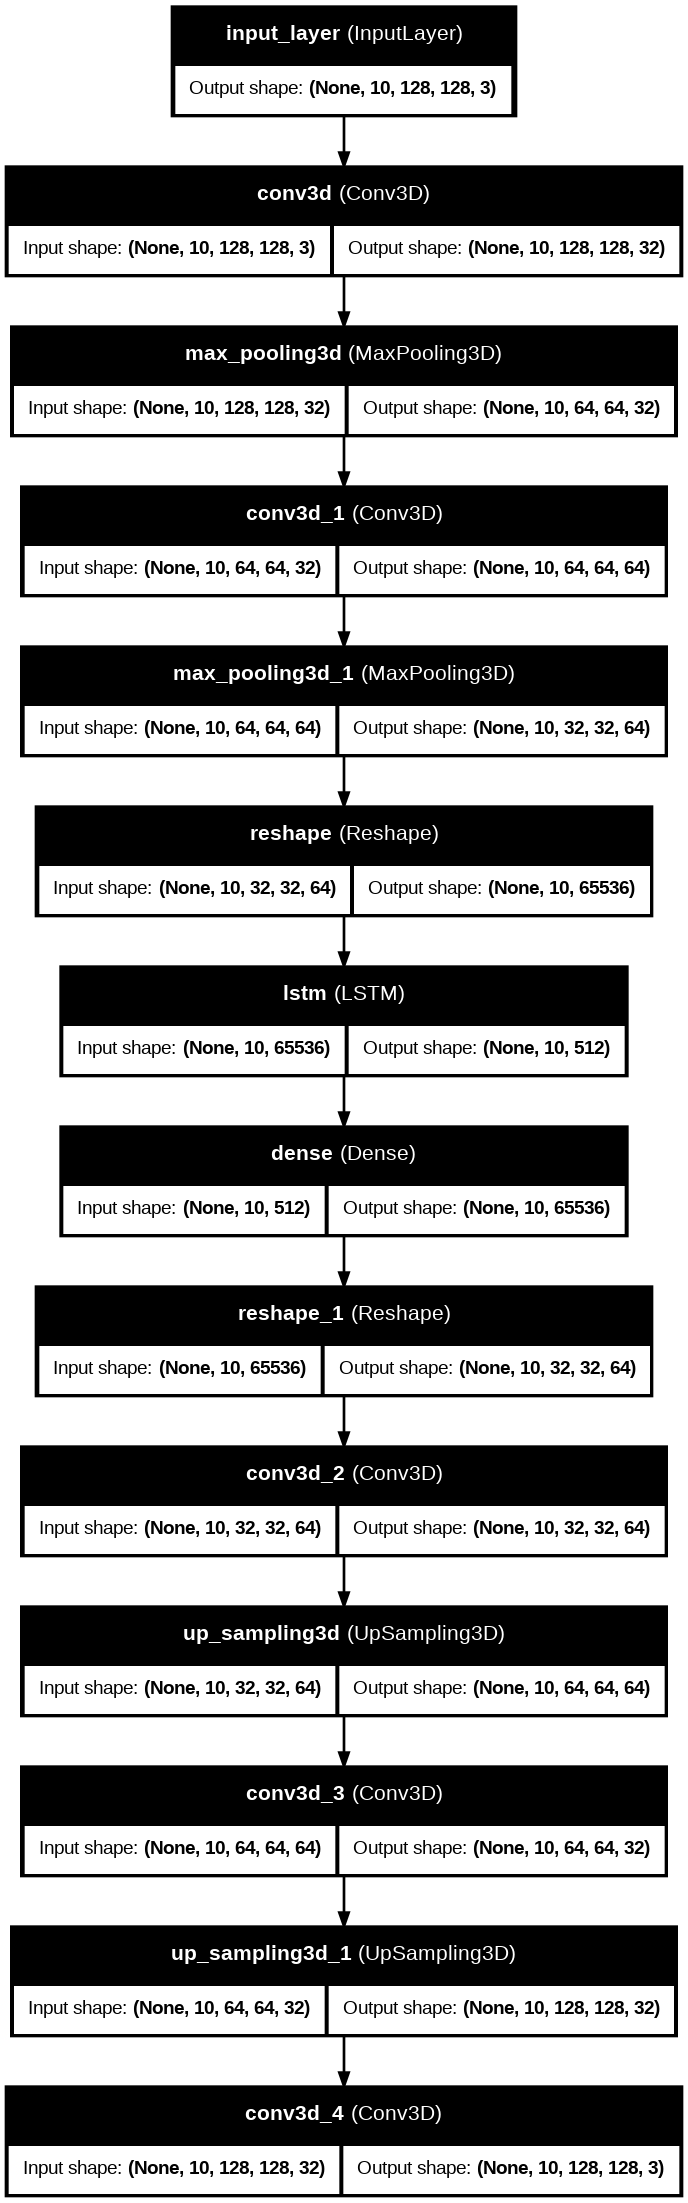

In [ ]:
from tensorflow.keras.utils import plot_model
# Plot the model architecture with specified image size and save it as PNG
plot_model(
    autoencoder,
    to_file='hybrid_autoencoder_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=96,          # Control resolution (dots per inch)
    expand_nested=True,  # Useful if your model has nested layers
)

# 3. Model Training and Evaluation

## 3.1 Helper functions for Evaluation and Training

In [ ]:
# Extract frames from the video

def extract_frames(video_path, target_size=(128, 128)):
    """Extract frames from the video and resize them to a consistent shape."""
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Stop if no more frames

        # Resize the frame to the target size
        frame = cv2.resize(frame, target_size)
        frames.append(frame)

    cap.release()
    return np.array(frames)  # Return as a NumPy array

# Calculate reconstruction error
def calculate_reconstruction_error(autoencoder, frames):
    reconstructions = autoencoder.predict(frames)
    errors = np.mean(np.square(frames - reconstructions), axis=(1, 2, 3))
    return np.median(errors)  # Use median to handle outliers


# Calculate SSIM between original and reconstructed frames
def calculate_ssim(frames, reconstructions):
    # Explicitly set win_size and data_range for SSIM calculation
    ssim_scores = [
        ssim(f, r, win_size=11, channel_axis=-1, data_range=1.0)
        for f, r in zip(frames, reconstructions)
    ]
    return np.mean(ssim_scores)  # Higher SSIM indicates better similarity

# Extract latent space features from encoder
def extract_latent_space(autoencoder, frames):
    # Extract latent space using the correct layer index
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[4].output)
    return encoder.predict(frames)

def cluster_latent_space(latent_vectors):
    # Get the number of samples
    num_samples = latent_vectors.shape[0]

    # Ensure the number of clusters does not exceed the number of samples
    n_clusters = min(5, num_samples)  # Use 5 clusters or fewer if samples are limited

    if n_clusters < 2:
        print("Not enough samples for clustering. Returning inertia as 0.")
        return 0  # Return 0 if clustering is not possible

    # Perform clustering with the adjusted cluster count
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(
        latent_vectors.reshape(len(latent_vectors), -1)
    )
    return kmeans.inertia_


def add_perturbation(value, epsilon=1e-6):
    return value + np.random.uniform(-epsilon, epsilon)

def compute_composite_score(reconstruction_error, ssim_score, clustering_inertia):
    # Add small noise to avoid identical values
    reconstruction_error = add_perturbation(reconstruction_error)
    ssim_score = add_perturbation(ssim_score)
    clustering_inertia = add_perturbation(clustering_inertia)

    metrics = np.array([
        [reconstruction_error],
        [-ssim_score],  # Negate SSIM as higher is better
        [clustering_inertia]
    ])

    scaler = MinMaxScaler()
    normalized_metrics = scaler.fit_transform(metrics).flatten()

    print(f"Normalized Metrics: {normalized_metrics}")  # Debugging output

    return np.sum(normalized_metrics)

# Create overlapping sequences from frames
def create_overlapping_sequences(frames, seq_length=10, stride=5):
    sequences = [
        frames[i:i + seq_length]
        for i in range(0, len(frames) - seq_length + 1, stride)
    ]
    return np.array(sequences)

#Data gen to reduce memory utilisation during training
class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, input_shape, batch_size=2, stride=5):
        self.video_paths = video_paths
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.stride = stride
        self.sequences = self._generate_sequences()

    def _generate_sequences(self):
        sequences = []
        for path in self.video_paths:
            frames = extract_frames(path)
            if frames.shape[0] >= self.input_shape[0]:
                seq = create_overlapping_sequences(frames, self.input_shape[0], self.stride)
                sequences.extend(seq)
        return sequences

    def __len__(self):
        return len(self.sequences) // self.batch_size

    def __getitem__(self, index):
        batch_sequences = self.sequences[index * self.batch_size: (index + 1) * self.batch_size]
        return np.array(batch_sequences) / 255.0, np.array(batch_sequences) / 255.0


# Function to evaluate video and return its composite score
def evaluate_video(video_path, autoencoder, input_shape):
    frames = extract_frames(video_path) / 255.0

    if frames.shape[0] < input_shape[0]:
        print(f"Warning: Not enough frames in {video_path}. Skipping.")
        return None

    # Create sequences of frames
    sequences = [
        frames[i:i + input_shape[0]] for i in range(0, frames.shape[0] - input_shape[0] + 1, input_shape[0])
    ]
    sequences = np.array(sequences)

    # Predict reconstructed sequences
    reconstructions = autoencoder.predict(sequences)

    # Calculate metrics
    recon_error = np.mean(np.square(sequences - reconstructions), axis=(1, 2, 3, 4)).mean()
    ssim_score = np.mean([
        calculate_ssim(seq, recon) for seq, recon in zip(sequences, reconstructions)
    ])
    latent_vectors = extract_latent_space(autoencoder, sequences)
    inertia = cluster_latent_space(latent_vectors)

    return compute_composite_score(recon_error, ssim_score, inertia)

# Helper function to extract video paths from a directory
def get_video_paths(directory):
    """Retrieve paths of all video files from a given directory."""
    return [os.path.join(directory, f) for f in os.listdir(directory)
            if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

## 3.2. Loading Data for Training


In [ ]:
# Path to the training videos directory (for google drive)
train_videos_directory  = '/content/gdrive/My Drive/Colab Notebooks/Best-Video-Selection/Data/Train'

# Get all video paths from the Google Drive directory
video_paths = [
    os.path.join(train_videos_directory, f) for f in os.listdir(train_videos_directory)
    if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))  # Filter video files
]

print(f"Found {len(video_paths)} videos.")

Found 25 videos.


In [ ]:
# # Path to the training videos directory (For local)
# # video_directory = r"C:\PRS\Marine-Vision\CreateMLModels\Best-Video-Selection\Data\Train"

# # Get all video paths from the directory
# video_paths = [os.path.join(video_directory, f) for f in os.listdir(video_directory)
#                if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]  # Filter video files

## 3.3 Training the autoencoder**

In [ ]:
# Define the input shape
batch_size = 4  # Adjust batch size based on memory constraints

# Get video paths from the specified directory
# video_paths = get_video_paths(video_directory) #(local)
video_paths = get_video_paths(train_videos_directory) #(gdrive)

# Initialize the data generator
data_generator = VideoDataGenerator(video_paths, input_shape, batch_size=batch_size)

# Define a checkpoint callback to save the best model
checkpoint_path = "best_autoencoder.keras"  # Use .keras instead of .h5

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='loss',  # Use 'val_loss' if you have validation data
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train the model with the checkpoint callback
history = autoencoder.fit(
    data_generator,
    epochs=30,
    callbacks=[checkpoint]
)
print(f"Best model saved to {checkpoint_path} during training.")


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1059/1059 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2139 - mae: 0.2132 - mse: 0.0692
Epoch 1: loss improved from inf to 0.09496, saving model to best_autoencoder.keras
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 98s 85ms/step - loss: 0.2138 - mae: 0.2132 - mse: 0.0692
Epoch 2/30
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0667 - mae: 0.2075 - mse: 0.0651
Epoch 2: loss improved from 0.09496 to 0.06617, saving model to best_autoencoder.keras
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 79s 75ms/step - loss: 0.0667 - mae: 0.2075 - mse: 0.0651
Epoch 3/30
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0650 - mae: 0.2045 - mse: 0.0634
Epoch 3: loss did not improve from 0.06617
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - loss: 0.0650 - mae: 0.2045 - mse: 0.0634
Epoch 4/30
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0663 - mae: 0.2082 - mse: 0.0650
Epoch 4: loss improved from 0.06617 to 0.06483, saving model to best_autoencoder.keras
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 76s 72ms/step - loss: 0.

# 3.4. Visualizing the training metrices

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'mse'])


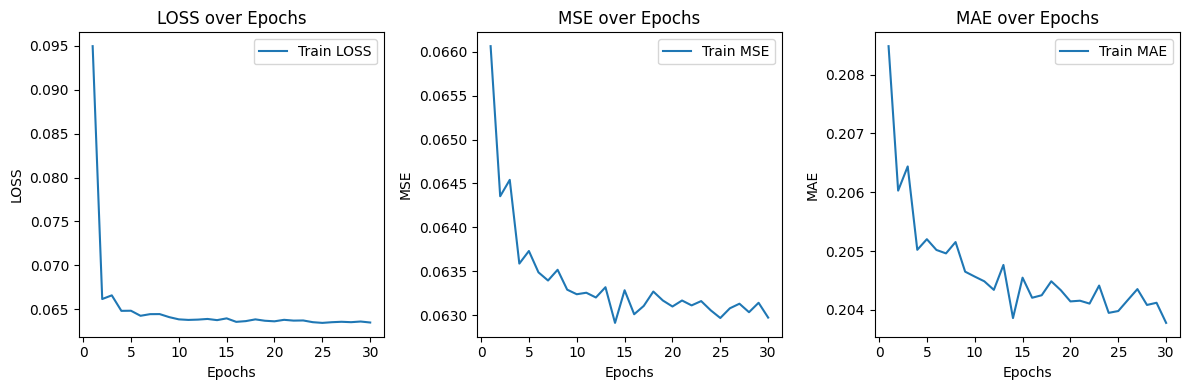

In [ ]:
def plot_training_metrics(history):
    """Plot loss, MSE, and MAE from training history."""
    available_metrics = ['loss', 'mse', 'mae']  # Updated metrics

    plt.figure(figsize=(12, 4))  # Adjust the figure size

    for i, metric in enumerate(available_metrics):
        if metric in history.history:
            plt.subplot(1, 3, i + 1)  # Create a 1x3 grid for metrics
            plt.plot(range(1, len(history.history[metric]) + 1), history.history[metric], label=f'Train {metric.upper()}')
            plt.xlabel('Epochs')
            plt.ylabel(metric.upper())
            plt.title(f'{metric.upper()} over Epochs')
            plt.legend()
        else:
            print(f"Warning: Metric '{metric}' not found in history.")

    plt.tight_layout()
    plt.show()

# Example usage after training
# history = autoencoder.fit(...)
plot_training_metrics(history)


# 4. Testing with mutiple sample videos from enhancement models to compare the scores

## 4.1. Loading sample Videos

In [ ]:
# Define the directories containing the videos
# video_directories = [
#     r"C:\PRS\Marine-Vision\CreateMLModels\Best-Video-Selection\Data\DeepSESR",
#     r"C:\PRS\Marine-Vision\CreateMLModels\Best-Video-Selection\Data\FUnieGan",
#     r"C:\PRS\Marine-Vision\CreateMLModels\Best-Video-Selection\Data\LDS-Net",
#     r"C:\PRS\Marine-Vision\CreateMLModels\Best-Video-Selection\Data\SeapixGan"
# ]


video_directories = [
   '/content/gdrive/My Drive/Colab Notebooks/Best-Video-Selection/Data/DeepSESR',
    '/content/gdrive/My Drive/Colab Notebooks/Best-Video-Selection/Data/FUnieGan',
   '/content/gdrive/My Drive/Colab Notebooks/Best-Video-Selection/Data/LDS-Net',
    '/content/gdrive/My Drive/Colab Notebooks/Best-Video-Selection/Data/SeapixGan'
]
# Create a list of paths to the 6.mp4 files from each directory
video_paths = [os.path.join(directory, "Ballena.mp4") for directory in video_directories]

# Ensure all paths exist and collect frames
all_frames = []

for path in video_paths:
    if not os.path.isfile(path):
        print(f"Warning: {path} does not exist.")
        continue  # Skip non-existent files

    frames = extract_frames(path)
    if frames.size == 0:
        print(f"Warning: No valid frames extracted from {path}.")
        continue  # Skip videos with no frames

    all_frames.append(frames)

# Check for consistent dimensions before concatenation
try:
    # Ensure all arrays have the same shape
    all_frames = np.array([f for f in all_frames if f.size > 0])  # Filter out empty arrays
    all_frames = np.concatenate(all_frames) / 255.0  # Normalize pixel values
except ValueError as e:
    print(f"Error during concatenation: {e}")
    exit(1)  # Exit if concatenation fails

## 4.2. Loading the traned auto encoder model

In [ ]:
def load_trained_model(model_path="best_autoencoder.keras"):
    """Load the trained model from the specified path."""
    try:
        model = load_model(model_path)
        print(f"Model loaded successfully from {model_path}.")
        return model
    except Exception as e:
        print(f"Error loading the model: {e}")
        return None

# Load the trained model
model = load_trained_model()

Model loaded successfully from best_autoencoder.keras.


## 4.3. Perfomring Inference

In [ ]:
input_shape = (10, 128, 128, 3)
# Evaluate videos
video_scores = []
for path in video_paths:
    score = evaluate_video(path, autoencoder, input_shape)
    if score is not None:
        video_scores.append((path, score))

# Rank videos by composite score
ranked_videos = sorted(video_scores, key=lambda x: x[1])
for video, score in ranked_videos:
    print(f"Video: {video}, Composite Score: {score}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Normalized Metrics: [1.       0.       0.933899]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Normalized Metrics: [1.        0.        0.9340228]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Normalized Metrics: [1.         0.         0.93318687]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Normalized Metrics: [1.         0.         0.93389462]
Video: /content/gdrive/My Drive/Colab Notebooks/Best-Video-Selection/Data/LDS-Net/Ballena.mp4, Composite Score: 1.9331868690156022
Video: /content/gdrive/My Drive/Colab Notebooks/Best-Video-Selection/Data/SeapixGan/Ballena.mp4, Composite Score: 1.9338946243917927
Video: /content/gdrive/My Drive/Colab Notebooks/Best-Video-Selection/Data/DeepSESR/Ballena.mp4, Composite Score: 1.9338990032766838
Video: /content/gdrive/My Drive/Colab Notebooks/Best-Video-Selection/Data/FUnieGan/Ballena.mp4, Composite Score: 1.934022798668543


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
